# Solar Flare Nanoflare Detection Analysis

This notebook analyzes GOES X-ray sensor data to detect nanoflares using enhanced visualizations and curve fitting techniques.

## Objectives:
- Load and truncate the 2022 XRSA/XRSB flux data to 1day=1440 samples
- Create enhanced visualizations using Seaborn
- Plot log-scale flux vs time for both XRSA and XRSB channels
- Implement curve fitting to detect nanoflare signatures
- Identify potential nanoflare events

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set ggplot2-inspired style for beautiful visualizations
plt.style.use('ggplot')  # Use ggplot style as base
sns.set_style("whitegrid")  # Clean white background with subtle grid
sns.set_palette("husl")  # Colorful, evenly spaced hues
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.8})

# Enhanced matplotlib styling with ggplot2 aesthetics
plt.rcParams.update({
    # Figure and background
    'figure.facecolor': '#fafafa',
    'axes.facecolor': '#ffffff',
    'savefig.facecolor': '#fafafa',
    
    # Grid styling (ggplot2-like)
    'axes.grid': True,
    'grid.color': '#e0e0e0',
    'grid.linewidth': 0.8,
    'grid.alpha': 0.7,
    'axes.axisbelow': True,
    
    # Axes and spines
    'axes.edgecolor': '#cccccc',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    
    # Text and labels (clean typography)
    'text.color': '#333333',
    'axes.labelcolor': '#333333',
    'xtick.color': '#555555',
    'ytick.color': '#555555',
    'font.family': ['DejaVu Sans', 'Helvetica', 'Arial', 'sans-serif'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    
    # Legend styling
    'legend.frameon': True,
    'legend.facecolor': 'white',
    'legend.edgecolor': '#cccccc',
    'legend.framealpha': 0.9,
    'legend.shadow': True,
    
    # Line and marker properties
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'patch.linewidth': 0.5,
    'patch.facecolor': '#4C72B0',
    'patch.edgecolor': '#333333',
    
    # Color cycle (ggplot2-inspired)
    'axes.prop_cycle': plt.cycler('color', [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
    ])
})

print("✨ ggplot2-inspired styling loaded successfully!")
print("🎨 Enhanced aesthetics activated for beautiful solar flare visualizations!")

✨ ggplot2-inspired styling loaded successfully!
🎨 Enhanced aesthetics activated for beautiful solar flare visualizations!


In [2]:
# Load the CSV data
data_path = 'data/2023_xrsa_xrsb.csv'
df = pd.read_csv(data_path)

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Original dataset shape: (525600, 4)
Columns: ['time_minutes', 'time_seconds', 'xrsa_flux_observed', 'xrsb_flux_observed']

First few rows:
   time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
0             0             0        8.923480e-08            0.000002
1             1            60        8.247599e-08            0.000001
2             2           120        7.758199e-08            0.000001
3             3           180        7.542049e-08            0.000001
4             4           240        7.351816e-08            0.000001

Missing values:
time_minutes              0
time_seconds              0
xrsa_flux_observed    16181
xrsb_flux_observed    16181
dtype: int64


In [3]:
# Clean the data and remove rows with missing values
df_clean = df.dropna()
print(f"Dataset shape after removing NaN values: {df_clean.shape}")

# Truncate to 0 to 1440 samples as requested
df_truncated = df_clean.iloc[:1440].copy()
#df_truncated = df_clean.head(2000).copy()
print(f"Truncated dataset shape: {df_truncated.shape}")

# Display basic statistics
print("\nBasic statistics of truncated dataset:")
print(df_truncated.describe())

Dataset shape after removing NaN values: (509419, 4)
Truncated dataset shape: (1440, 4)

Basic statistics of truncated dataset:
       time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
count   1440.000000    1440.00000        1.440000e+03        1.440000e+03
mean     719.500000   43170.00000        7.193186e-08        1.294268e-06
std      415.836506   24950.19038        3.805819e-08        4.027178e-07
min        0.000000       0.00000        3.686430e-08        9.126298e-07
25%      359.750000   21585.00000        5.655426e-08        1.052728e-06
50%      719.500000   43170.00000        6.406091e-08        1.188996e-06
75%     1079.250000   64755.00000        7.344845e-08        1.399207e-06
max     1439.000000   86340.00000        3.909671e-07        3.861059e-06


In [4]:
# Prepare data for analysis
time_minutes = df_truncated['time_minutes'].values
xrsa_flux = df_truncated['xrsa_flux_observed'].values
xrsb_flux = df_truncated['xrsb_flux_observed'].values

# Calculate log values (handle potential zero or negative values)
# Add small epsilon to avoid log(0)
epsilon = 1e-12
log_xrsa = np.log10(np.maximum(xrsa_flux, epsilon))
log_xrsb = np.log10(np.maximum(xrsb_flux, epsilon))

print(f"Time range: {time_minutes.min():.1f} to {time_minutes.max():.1f} minutes")
print(f"XRSA flux range: {xrsa_flux.min():.2e} to {xrsa_flux.max():.2e}")
print(f"XRSB flux range: {xrsb_flux.min():.2e} to {xrsb_flux.max():.2e}")
print(f"Log XRSA range: {log_xrsa.min():.2f} to {log_xrsa.max():.2f}")
print(f"Log XRSB range: {log_xrsb.min():.2f} to {log_xrsb.max():.2f}")

Time range: 0.0 to 1439.0 minutes
XRSA flux range: 3.69e-08 to 3.91e-07
XRSB flux range: 9.13e-07 to 3.86e-06
Log XRSA range: -7.43 to -6.41
Log XRSB range: -6.04 to -5.41


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

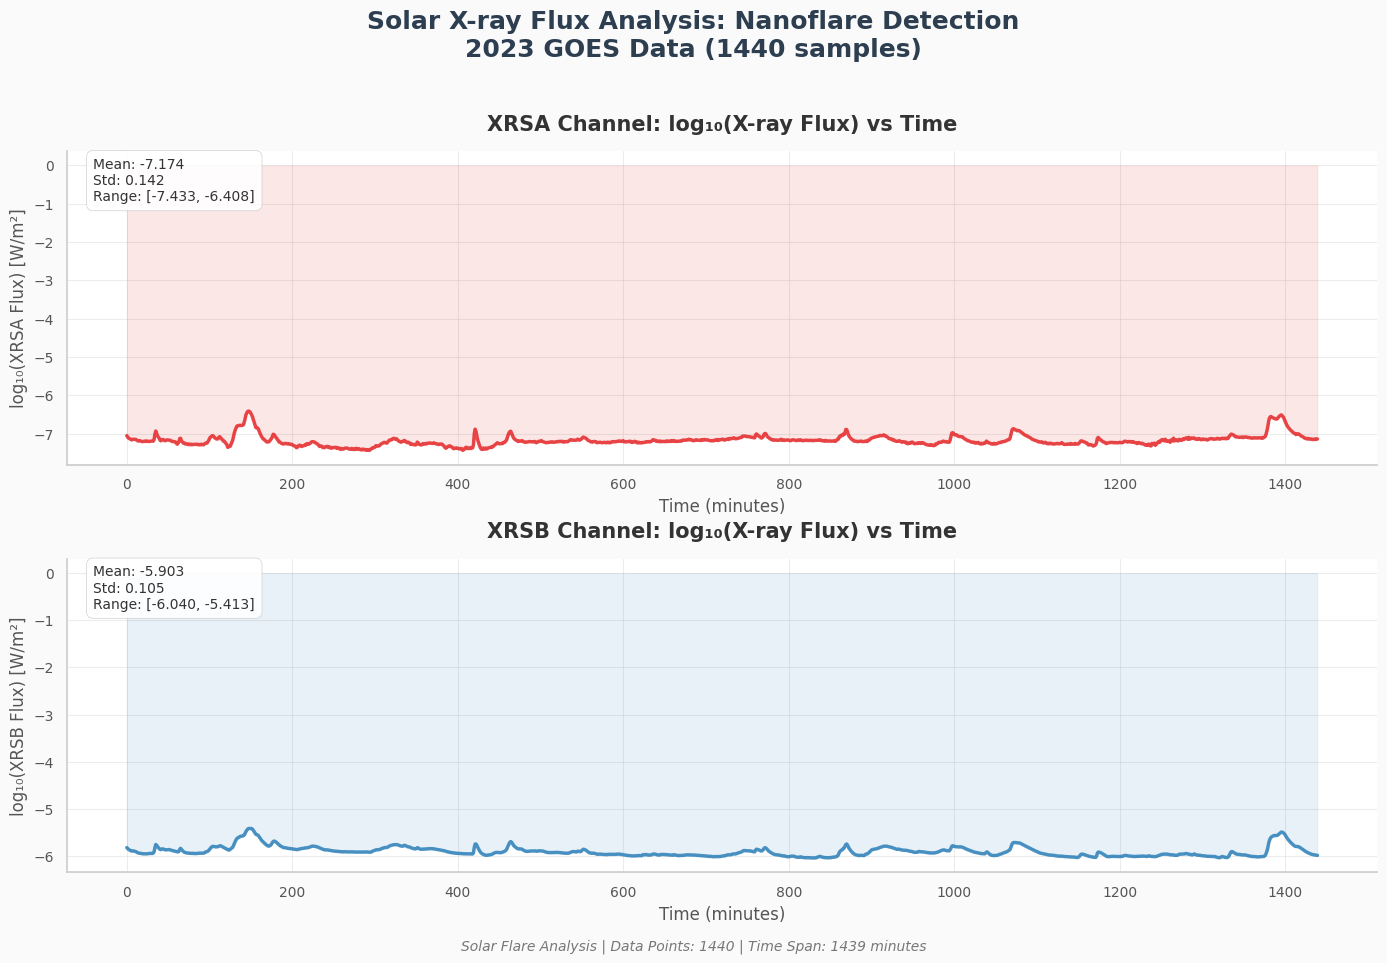

✨ Enhanced ggplot2-inspired visualization created successfully!
📊 XRSA: Range [-7.433, -6.408], Mean: -7.174
📊 XRSB: Range [-6.040, -5.413], Mean: -5.903


In [5]:
# Create enhanced visualizations using ggplot2-inspired aesthetics
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('Solar X-ray Flux Analysis: Nanoflare Detection\n2023 GOES Data (1440 samples)', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Enhanced color palette
colors = ['#E31A1C', '#1F78B4', '#33A02C', '#FF7F00', '#6A3D9A']

# Plot 1: log(XRSA flux) vs time with ggplot2 aesthetics
axes[0].plot(time_minutes, log_xrsa, color=colors[0], linewidth=2.5, alpha=0.8, label='XRSA Channel')
axes[0].fill_between(time_minutes, log_xrsa, alpha=0.1, color=colors[0])
axes[0].set_title('XRSA Channel: log₁₀(X-ray Flux) vs Time', 
                  fontsize=15, fontweight='bold', color='#333333', pad=15)
axes[0].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[0].set_ylabel('log₁₀(XRSA Flux) [W/m²]', fontsize=12, color='#555555')

# Remove top and right spines for cleaner look
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_color('#cccccc')
axes[0].spines['bottom'].set_color('#cccccc')

# Enhanced grid
axes[0].grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
axes[0].set_axisbelow(True)
axes[0].set_facecolor('white')

# Add summary statistics as text box
xrsa_stats = f'Mean: {np.mean(log_xrsa):.3f}\nStd: {np.std(log_xrsa):.3f}\nRange: [{log_xrsa.min():.3f}, {log_xrsa.max():.3f}]'
axes[0].text(0.02, 0.98, xrsa_stats, transform=axes[0].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
            facecolor='white', alpha=0.9, edgecolor='#cccccc'))

# Plot 2: log(XRSB flux) vs time with ggplot2 aesthetics
axes[1].plot(time_minutes, log_xrsb, color=colors[1], linewidth=2.5, alpha=0.8, label='XRSB Channel')
axes[1].fill_between(time_minutes, log_xrsb, alpha=0.1, color=colors[1])
axes[1].set_title('XRSB Channel: log₁₀(X-ray Flux) vs Time', 
                  fontsize=15, fontweight='bold', color='#333333', pad=15)
axes[1].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1].set_ylabel('log₁₀(XRSB Flux) [W/m²]', fontsize=12, color='#555555')

# Remove top and right spines for cleaner look
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_color('#cccccc')
axes[1].spines['bottom'].set_color('#cccccc')

# Enhanced grid
axes[1].grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
axes[1].set_axisbelow(True)
axes[1].set_facecolor('white')

# Add summary statistics as text box
xrsb_stats = f'Mean: {np.mean(log_xrsb):.3f}\nStd: {np.std(log_xrsb):.3f}\nRange: [{log_xrsb.min():.3f}, {log_xrsb.max():.3f}]'
axes[1].text(0.02, 0.98, xrsb_stats, transform=axes[1].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
            facecolor='white', alpha=0.9, edgecolor='#cccccc'))

# Enhanced layout
plt.tight_layout(rect=[0, 0.02, 1, 0.93])
plt.subplots_adjust(hspace=0.3)

# Add footer
fig.text(0.5, 0.01, f'Solar Flare Analysis | Data Points: {len(time_minutes)} | Time Span: {time_minutes[-1] - time_minutes[0]:.0f} minutes',
         ha='center', fontsize=10, color='#777777', style='italic')

plt.show()

print("✨ Enhanced ggplot2-inspired visualization created successfully!")
print(f"📊 XRSA: Range [{log_xrsa.min():.3f}, {log_xrsa.max():.3f}], Mean: {np.mean(log_xrsa):.3f}")
print(f"📊 XRSB: Range [{log_xrsb.min():.3f}, {log_xrsb.max():.3f}], Mean: {np.mean(log_xrsb):.3f}")

Now I want to flat the baseline of (log(xrsa) vs time ) using baseline correction . 


also baseline correction to log(xrsb) vs time 

findfont: Font family 'Helvetica' not found.


pybaselines already installed


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

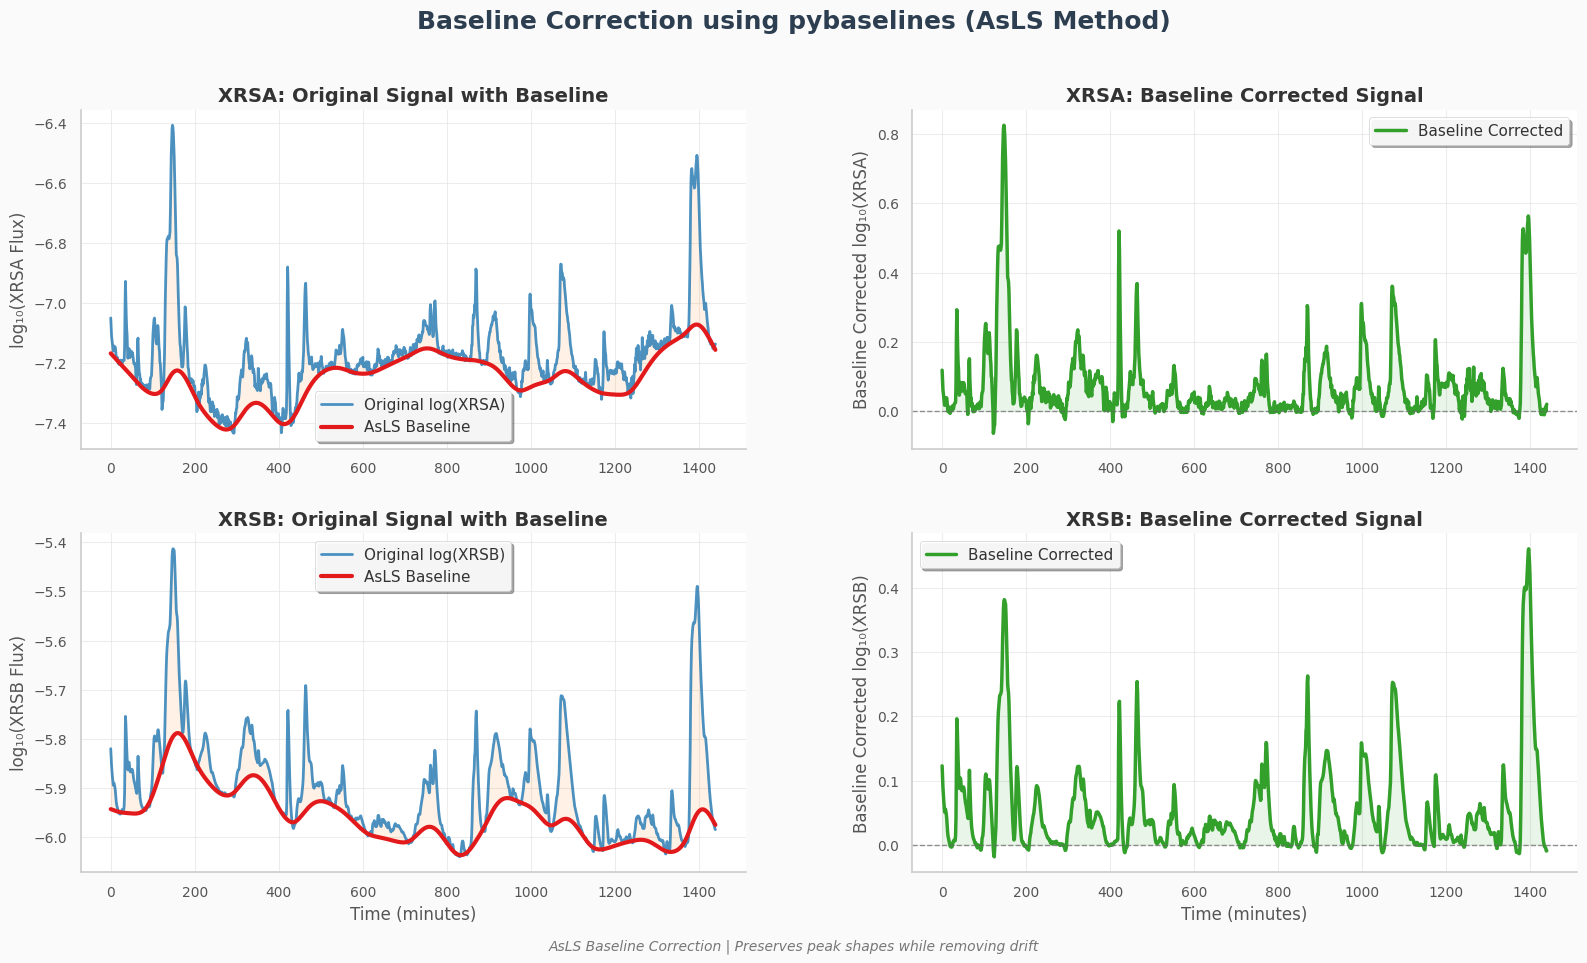

✨ Baseline correction completed using ggplot2-inspired AsLS method!
📊 XRSA baseline correction stats:
  - Original std: 0.142167
  - Corrected std: 0.112728
  - Noise reduction: 20.7%
📊 XRSB baseline correction stats:
  - Original std: 0.105320
  - Corrected std: 0.075730
  - Noise reduction: 28.1%


In [6]:
import subprocess
import sys

# Install and import pybaselines for advanced baseline correction
try:
    from pybaselines import Baseline
    print("pybaselines already installed")
except ImportError:
    print("Installing pybaselines...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pybaselines"])
    from pybaselines import Baseline
    print("pybaselines installed and imported successfully")

# Initialize the baseline correction object
baseline_fitter = Baseline(time_minutes)

# Apply AsLS (Asymmetric Least Squares) baseline correction to log(XRSA)
xrsa_result = baseline_fitter.asls(log_xrsa, lam=1e4, p=0.01)
xrsa_baseline = xrsa_result[0]
xrsa_corrected = log_xrsa - xrsa_baseline

# Apply AsLS baseline correction to log(XRSB) 
xrsb_result = baseline_fitter.asls(log_xrsb, lam=1e4, p=0.01)
xrsb_baseline = xrsb_result[0]
xrsb_corrected = log_xrsb - xrsb_baseline

# Create ggplot2-inspired baseline correction visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('Baseline Correction using pybaselines (AsLS Method)', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Color palette
colors = {
    'original': '#1F78B4',
    'baseline': '#E31A1C', 
    'corrected': '#33A02C',
    'fill': '#FF7F00'
}

# XRSA plots
axes[0,0].plot(time_minutes, log_xrsa, color=colors['original'], linewidth=2, alpha=0.8, label='Original log(XRSA)')
axes[0,0].plot(time_minutes, xrsa_baseline, color=colors['baseline'], linewidth=3, label='AsLS Baseline')
axes[0,0].fill_between(time_minutes, log_xrsa, xrsa_baseline, alpha=0.1, color=colors['fill'])
axes[0,0].set_title('XRSA: Original Signal with Baseline', fontsize=14, fontweight='bold', color='#333333')
axes[0,0].set_ylabel('log₁₀(XRSA Flux)', fontsize=12, color='#555555')

# Clean styling
for ax in [axes[0,0]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)

axes[0,1].plot(time_minutes, xrsa_corrected, color=colors['corrected'], linewidth=2.5, label='Baseline Corrected')
axes[0,1].axhline(y=0, color='#666666', linestyle='--', alpha=0.7, linewidth=1)
axes[0,1].fill_between(time_minutes, xrsa_corrected, alpha=0.1, color=colors['corrected'])
axes[0,1].set_title('XRSA: Baseline Corrected Signal', fontsize=14, fontweight='bold', color='#333333')
axes[0,1].set_ylabel('Baseline Corrected log₁₀(XRSA)', fontsize=12, color='#555555')

for ax in [axes[0,1]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)

# XRSB plots
axes[1,0].plot(time_minutes, log_xrsb, color=colors['original'], linewidth=2, alpha=0.8, label='Original log(XRSB)')
axes[1,0].plot(time_minutes, xrsb_baseline, color=colors['baseline'], linewidth=3, label='AsLS Baseline')
axes[1,0].fill_between(time_minutes, log_xrsb, xrsb_baseline, alpha=0.1, color=colors['fill'])
axes[1,0].set_title('XRSB: Original Signal with Baseline', fontsize=14, fontweight='bold', color='#333333')
axes[1,0].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,0].set_ylabel('log₁₀(XRSB Flux)', fontsize=12, color='#555555')

for ax in [axes[1,0]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)

axes[1,1].plot(time_minutes, xrsb_corrected, color=colors['corrected'], linewidth=2.5, label='Baseline Corrected')
axes[1,1].axhline(y=0, color='#666666', linestyle='--', alpha=0.7, linewidth=1)
axes[1,1].fill_between(time_minutes, xrsb_corrected, alpha=0.1, color=colors['corrected'])
axes[1,1].set_title('XRSB: Baseline Corrected Signal', fontsize=14, fontweight='bold', color='#333333')
axes[1,1].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,1].set_ylabel('Baseline Corrected log₁₀(XRSB)', fontsize=12, color='#555555')

for ax in [axes[1,1]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)

plt.tight_layout(rect=[0, 0.02, 1, 0.93])
plt.subplots_adjust(hspace=0.25, wspace=0.25)

# Add footer
fig.text(0.5, 0.01, 'AsLS Baseline Correction | Preserves peak shapes while removing drift',
         ha='center', fontsize=10, color='#777777', style='italic')

plt.show()

print("✨ Baseline correction completed using ggplot2-inspired AsLS method!")
print(f"📊 XRSA baseline correction stats:")
print(f"  - Original std: {np.std(log_xrsa):.6f}")
print(f"  - Corrected std: {np.std(xrsa_corrected):.6f}")
print(f"  - Noise reduction: {(1 - np.std(xrsa_corrected)/np.std(log_xrsa))*100:.1f}%")
print(f"📊 XRSB baseline correction stats:")
print(f"  - Original std: {np.std(log_xrsb):.6f}")
print(f"  - Corrected std: {np.std(xrsb_corrected):.6f}")
print(f"  - Noise reduction: {(1 - np.std(xrsb_corrected)/np.std(log_xrsb))*100:.1f}%")

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

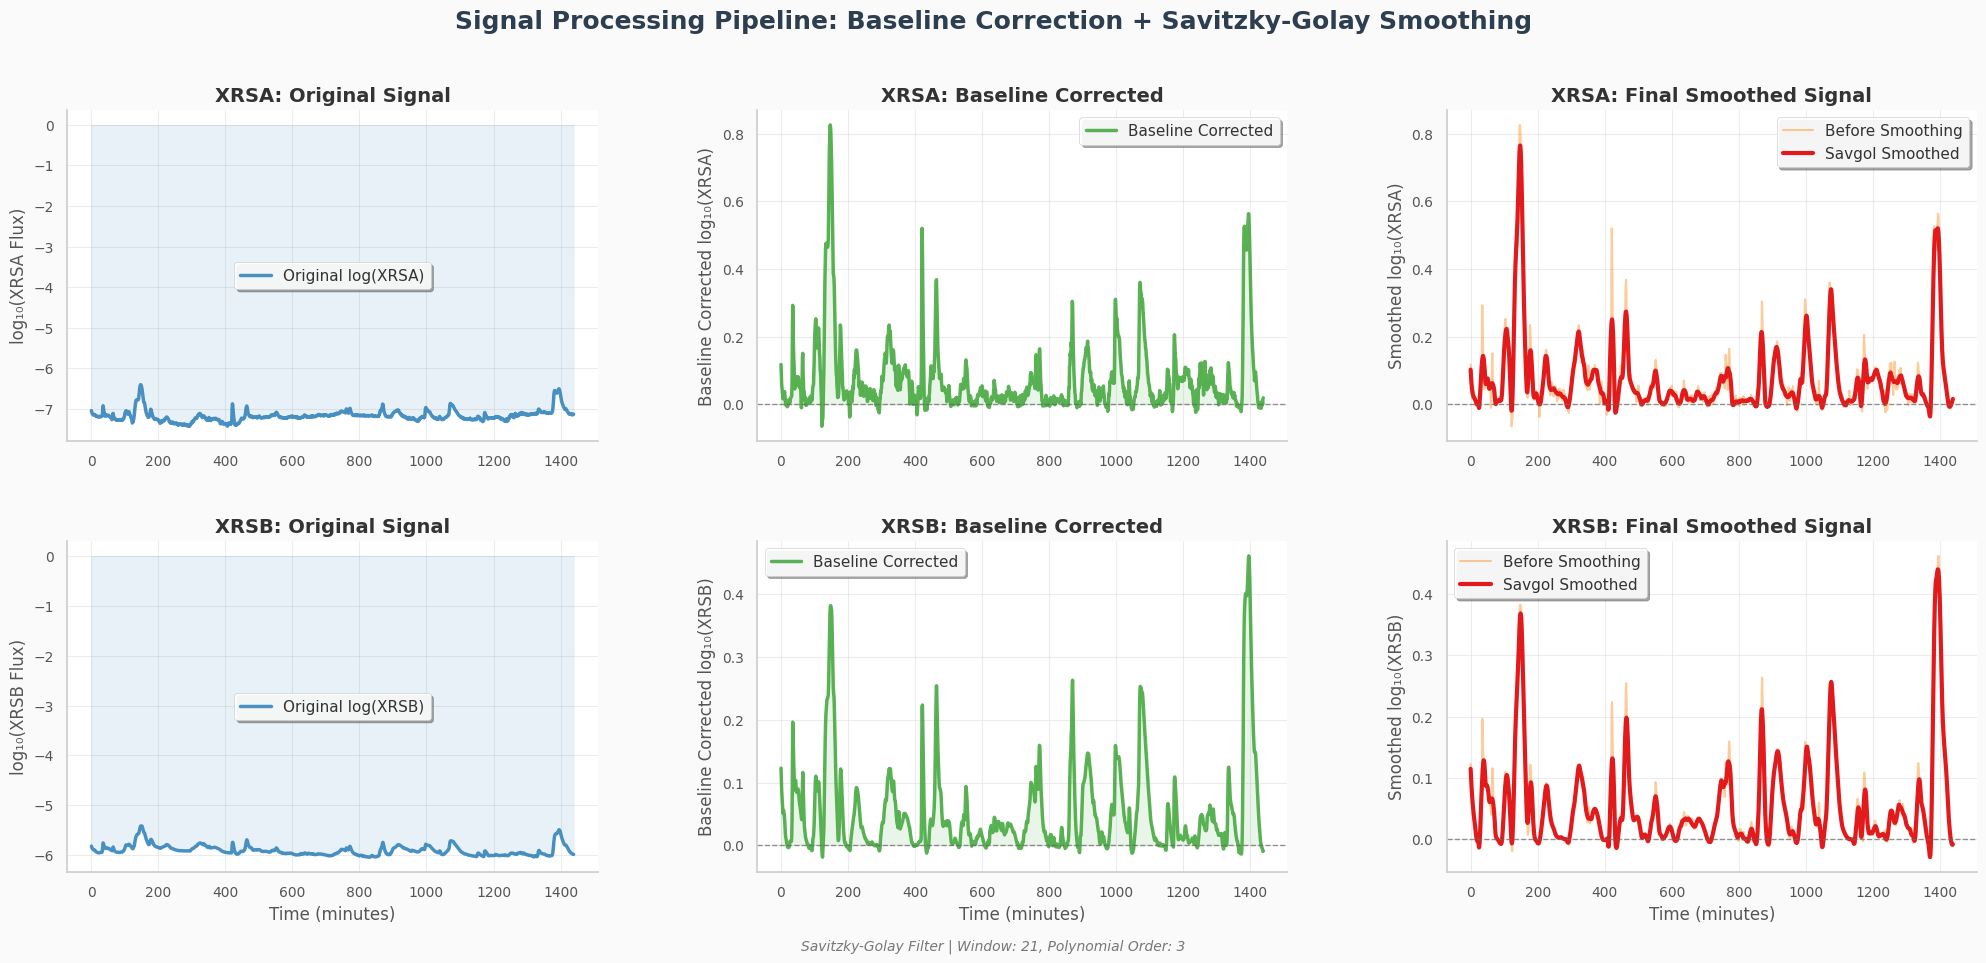

✨ Savitzky-Golay smoothing completed with ggplot2 aesthetics!
🔧 Filter parameters: window_length=21, polyorder=3

📊 XRSA signal processing stats:
  - Original std: 0.142167
  - Baseline corrected std: 0.112728
  - Final smoothed std: 0.107803

📊 XRSB signal processing stats:
  - Original std: 0.105320
  - Baseline corrected std: 0.075730
  - Final smoothed std: 0.073747

🎯 Noise reduction achieved:
  - XRSA: 24.2% reduction in signal variability
  - XRSB: 30.0% reduction in signal variability


In [7]:
# Apply Savitzky-Golay filter to smooth the baseline-corrected signals
from scipy.signal import savgol_filter

# Choose filter parameters
window_length = 21  # Must be odd and > polyorder
polyorder = 3       # Polynomial order for fitting

# Apply Savitzky-Golay filter to baseline-corrected signals
xrsa_smoothed = savgol_filter(xrsa_corrected, window_length, polyorder)
xrsb_smoothed = savgol_filter(xrsb_corrected, window_length, polyorder)

# Create ggplot2-inspired comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('Signal Processing Pipeline: Baseline Correction + Savitzky-Golay Smoothing', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Enhanced color palette
colors = {
    'original': '#1F78B4',    # Blue
    'corrected': '#33A02C',   # Green  
    'smoothed': '#E31A1C',    # Red
    'comparison': '#FF7F00'   # Orange
}

# Helper function to style axes
def style_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')

# XRSA processing chain
# Original signal
axes[0,0].plot(time_minutes, log_xrsa, color=colors['original'], linewidth=2.5, alpha=0.8, label='Original log(XRSA)')
axes[0,0].fill_between(time_minutes, log_xrsa, alpha=0.1, color=colors['original'])
axes[0,0].set_title('XRSA: Original Signal', fontsize=14, fontweight='bold', color='#333333')
axes[0,0].set_ylabel('log₁₀(XRSA Flux)', fontsize=12, color='#555555')
axes[0,0].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)
style_axis(axes[0,0])

# Baseline corrected
axes[0,1].plot(time_minutes, xrsa_corrected, color=colors['corrected'], linewidth=2.5, alpha=0.8, label='Baseline Corrected')
axes[0,1].fill_between(time_minutes, xrsa_corrected, alpha=0.1, color=colors['corrected'])
axes[0,1].axhline(y=0, color='#666666', linestyle='--', alpha=0.7, linewidth=1)
axes[0,1].set_title('XRSA: Baseline Corrected', fontsize=14, fontweight='bold', color='#333333')
axes[0,1].set_ylabel('Baseline Corrected log₁₀(XRSA)', fontsize=12, color='#555555')
axes[0,1].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)
style_axis(axes[0,1])

# Final smoothed with comparison
axes[0,2].plot(time_minutes, xrsa_corrected, color=colors['comparison'], linewidth=1.5, alpha=0.4, label='Before Smoothing')
axes[0,2].plot(time_minutes, xrsa_smoothed, color=colors['smoothed'], linewidth=3, label='Savgol Smoothed')
axes[0,2].axhline(y=0, color='#666666', linestyle='--', alpha=0.7, linewidth=1)
axes[0,2].set_title('XRSA: Final Smoothed Signal', fontsize=14, fontweight='bold', color='#333333')
axes[0,2].set_ylabel('Smoothed log₁₀(XRSA)', fontsize=12, color='#555555')
axes[0,2].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)
style_axis(axes[0,2])

# XRSB processing chain  
# Original signal
axes[1,0].plot(time_minutes, log_xrsb, color=colors['original'], linewidth=2.5, alpha=0.8, label='Original log(XRSB)')
axes[1,0].fill_between(time_minutes, log_xrsb, alpha=0.1, color=colors['original'])
axes[1,0].set_title('XRSB: Original Signal', fontsize=14, fontweight='bold', color='#333333')
axes[1,0].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,0].set_ylabel('log₁₀(XRSB Flux)', fontsize=12, color='#555555')
axes[1,0].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)
style_axis(axes[1,0])

# Baseline corrected
axes[1,1].plot(time_minutes, xrsb_corrected, color=colors['corrected'], linewidth=2.5, alpha=0.8, label='Baseline Corrected')
axes[1,1].fill_between(time_minutes, xrsb_corrected, alpha=0.1, color=colors['corrected'])
axes[1,1].axhline(y=0, color='#666666', linestyle='--', alpha=0.7, linewidth=1)
axes[1,1].set_title('XRSB: Baseline Corrected', fontsize=14, fontweight='bold', color='#333333')
axes[1,1].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,1].set_ylabel('Baseline Corrected log₁₀(XRSB)', fontsize=12, color='#555555')
axes[1,1].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)
style_axis(axes[1,1])

# Final smoothed with comparison
axes[1,2].plot(time_minutes, xrsb_corrected, color=colors['comparison'], linewidth=1.5, alpha=0.4, label='Before Smoothing')
axes[1,2].plot(time_minutes, xrsb_smoothed, color=colors['smoothed'], linewidth=3, label='Savgol Smoothed')
axes[1,2].axhline(y=0, color='#666666', linestyle='--', alpha=0.7, linewidth=1)
axes[1,2].set_title('XRSB: Final Smoothed Signal', fontsize=14, fontweight='bold', color='#333333')
axes[1,2].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,2].set_ylabel('Smoothed log₁₀(XRSB)', fontsize=12, color='#555555')
axes[1,2].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.9)
style_axis(axes[1,2])

plt.tight_layout(rect=[0, 0.02, 1, 0.93])
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Add footer
fig.text(0.5, 0.01, f'Savitzky-Golay Filter | Window: {window_length}, Polynomial Order: {polyorder}',
         ha='center', fontsize=10, color='#777777', style='italic')

plt.show()

print("✨ Savitzky-Golay smoothing completed with ggplot2 aesthetics!")
print(f"🔧 Filter parameters: window_length={window_length}, polyorder={polyorder}")
print(f"\n📊 XRSA signal processing stats:")
print(f"  - Original std: {np.std(log_xrsa):.6f}")
print(f"  - Baseline corrected std: {np.std(xrsa_corrected):.6f}")
print(f"  - Final smoothed std: {np.std(xrsa_smoothed):.6f}")
print(f"\n📊 XRSB signal processing stats:")
print(f"  - Original std: {np.std(log_xrsb):.6f}")
print(f"  - Baseline corrected std: {np.std(xrsb_corrected):.6f}")
print(f"  - Final smoothed std: {np.std(xrsb_smoothed):.6f}")

# Calculate noise reduction percentages
xrsa_noise_reduction = (1 - np.std(xrsa_smoothed) / np.std(log_xrsa)) * 100
xrsb_noise_reduction = (1 - np.std(xrsb_smoothed) / np.std(log_xrsb)) * 100
print(f"\n🎯 Noise reduction achieved:")
print(f"  - XRSA: {xrsa_noise_reduction:.1f}% reduction in signal variability")
print(f"  - XRSB: {xrsb_noise_reduction:.1f}% reduction in signal variability")

now , use savgol filter to Smooth noisy signals without distorting peak shapes on the baseline correction on XRSA

use savgol filter to Smooth noisy signals without distorting peak shapes on the baseline correction of log(xrsb) vs time 


In [ ]:
# Create ggplot2-inspired linear scale flux visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 11))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('Enhanced Solar X-ray Flux Analysis: Linear Scale\n2023 GOES Data', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Calculate statistics for annotations
xrsa_mean = np.mean(xrsa_flux)
xrsa_std = np.std(xrsa_flux)
xrsb_mean = np.mean(xrsb_flux)
xrsb_std = np.std(xrsb_flux)

# Enhanced ggplot2-inspired color scheme
colors = {
    'xrsa': '#E31A1C',      # Red
    'xrsb': '#1F78B4',      # Blue
    'mean': '#FF7F00',      # Orange
    'fill': 0.15,           # Fill alpha
    'grid': '#e0e0e0'       # Grid color
}

# Helper function for ggplot2 styling
def apply_ggplot_style(ax, color):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color=colors['grid'], linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.tick_params(colors='#555555')

# Plot 1: Enhanced XRSA flux vs time
axes[0].plot(time_minutes, xrsa_flux, color=colors['xrsa'], linewidth=2.8, alpha=0.9, label='XRSA Flux')
axes[0].fill_between(time_minutes, xrsa_flux, alpha=colors['fill'], color=colors['xrsa'])

# Add mean line with enhanced styling
axes[0].axhline(y=xrsa_mean, color=colors['mean'], linestyle=':', 
                alpha=0.8, linewidth=2.5, label=f'Mean: {xrsa_mean:.2e} W/m²')

# Enhanced styling
axes[0].set_title('XRSA Channel (0.05-0.4 nm): Enhanced X-ray Flux Analysis', 
                  fontsize=15, fontweight='bold', color='#333333', pad=20)
axes[0].set_xlabel('Time (minutes from start)', fontsize=13, color='#555555')
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=13, color='#555555')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Apply ggplot2 styling
apply_ggplot_style(axes[0], colors['xrsa'])

# Enhanced legend with ggplot2 styling
axes[0].legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
               fontsize=11, framealpha=0.95, facecolor='white', edgecolor='#cccccc')

# Add enhanced statistics box
stats_text = f'Statistics:\nMean: {xrsa_mean:.2e}\nStd: {xrsa_std:.2e}\nMax: {np.max(xrsa_flux):.2e}\nSamples: {len(xrsa_flux)}'
axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.6', 
             facecolor='white', alpha=0.95, edgecolor='#cccccc', linewidth=1.2))

# Plot 2: Enhanced XRSB flux vs time  
axes[1].plot(time_minutes, xrsb_flux, color=colors['xrsb'], linewidth=2.8, alpha=0.9, label='XRSB Flux')
axes[1].fill_between(time_minutes, xrsb_flux, alpha=colors['fill'], color=colors['xrsb'])

# Add mean line with enhanced styling
axes[1].axhline(y=xrsb_mean, color=colors['mean'], linestyle=':', 
                alpha=0.8, linewidth=2.5, label=f'Mean: {xrsb_mean:.2e} W/m²')

# Enhanced styling
axes[1].set_title('XRSB Channel (0.1-0.8 nm): Enhanced X-ray Flux Analysis', 
                  fontsize=15, fontweight='bold', color='#333333', pad=20)
axes[1].set_xlabel('Time (minutes from start)', fontsize=13, color='#555555')
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=13, color='#555555')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Apply ggplot2 styling
apply_ggplot_style(axes[1], colors['xrsb'])

# Enhanced legend with ggplot2 styling
axes[1].legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
               fontsize=11, framealpha=0.95, facecolor='white', edgecolor='#cccccc')

# Add enhanced statistics box
stats_text = f'Statistics:\nMean: {xrsb_mean:.2e}\nStd: {xrsb_std:.2e}\nMax: {np.max(xrsb_flux):.2e}\nSamples: {len(xrsb_flux)}'
axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.6', 
             facecolor='white', alpha=0.95, edgecolor='#cccccc', linewidth=1.2))

# Enhanced layout with ggplot2 spacing
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.subplots_adjust(hspace=0.35)

# Add enhanced footer with metadata
footer_text = (f'Time Range: {time_minutes[0]:.0f}-{time_minutes[-1]:.0f} min | '
               f'Duration: {(time_minutes[-1] - time_minutes[0])/60:.1f} hrs | '
               f'Data Points: {len(time_minutes)} | GOES X-ray Analysis')
fig.text(0.5, 0.02, footer_text, ha='center', fontsize=11, color='#777777', 
         style='italic', bbox=dict(boxstyle='round,pad=0.3', facecolor='#f5f5f5', alpha=0.8))

plt.show()

# Enhanced summary output with emojis
print("✨ ENHANCED GGPLOT2-INSPIRED LINEAR SCALE VISUALIZATION COMPLETED ✨")
print("=" * 70)
print(f"📊 Dataset Overview:")
print(f"   • Total data points: {len(time_minutes):,}")
print(f"   • Time span: {time_minutes[-1] - time_minutes[0]:.0f} minutes ({(time_minutes[-1] - time_minutes[0])/60:.1f} hours)")
print(f"   • Sampling rate: {time_minutes[1] - time_minutes[0]:.1f} minutes/point")
print()
print(f"? XRSA Channel Analysis:")
print(f"   • Mean flux: {xrsa_mean:.3e} W/m²")
print(f"   • Standard deviation: {xrsa_std:.3e} W/m²")
print(f"   • Peak flux: {np.max(xrsa_flux):.3e} W/m²")
print(f"   • Variability: {(xrsa_std/xrsa_mean)*100:.2f}%")
print()
print(f"? XRSB Channel Analysis:")
print(f"   • Mean flux: {xrsb_mean:.3e} W/m²")
print(f"   • Standard deviation: {xrsb_std:.3e} W/m²")
print(f"   • Peak flux: {np.max(xrsb_flux):.3e} W/m²")
print(f"   • Variability: {(xrsb_std/xrsb_mean)*100:.2f}%")
print()
print(f"🔗 Cross-Channel Comparison:")
print(f"   • XRSB/XRSA flux ratio: {xrsb_mean/xrsa_mean:.2f}")
print(f"   • Correlation coefficient: {np.corrcoef(xrsa_flux, xrsb_flux)[0,1]:.4f}")
print("=" * 70)

Full dataset contains 509419 samples
Time range: 0.0 to 525599.0 minutes
Total observation time: 8760.0 hours
Time range in days: 0.00 to 365.00 days
Total observation time: 365.0 days


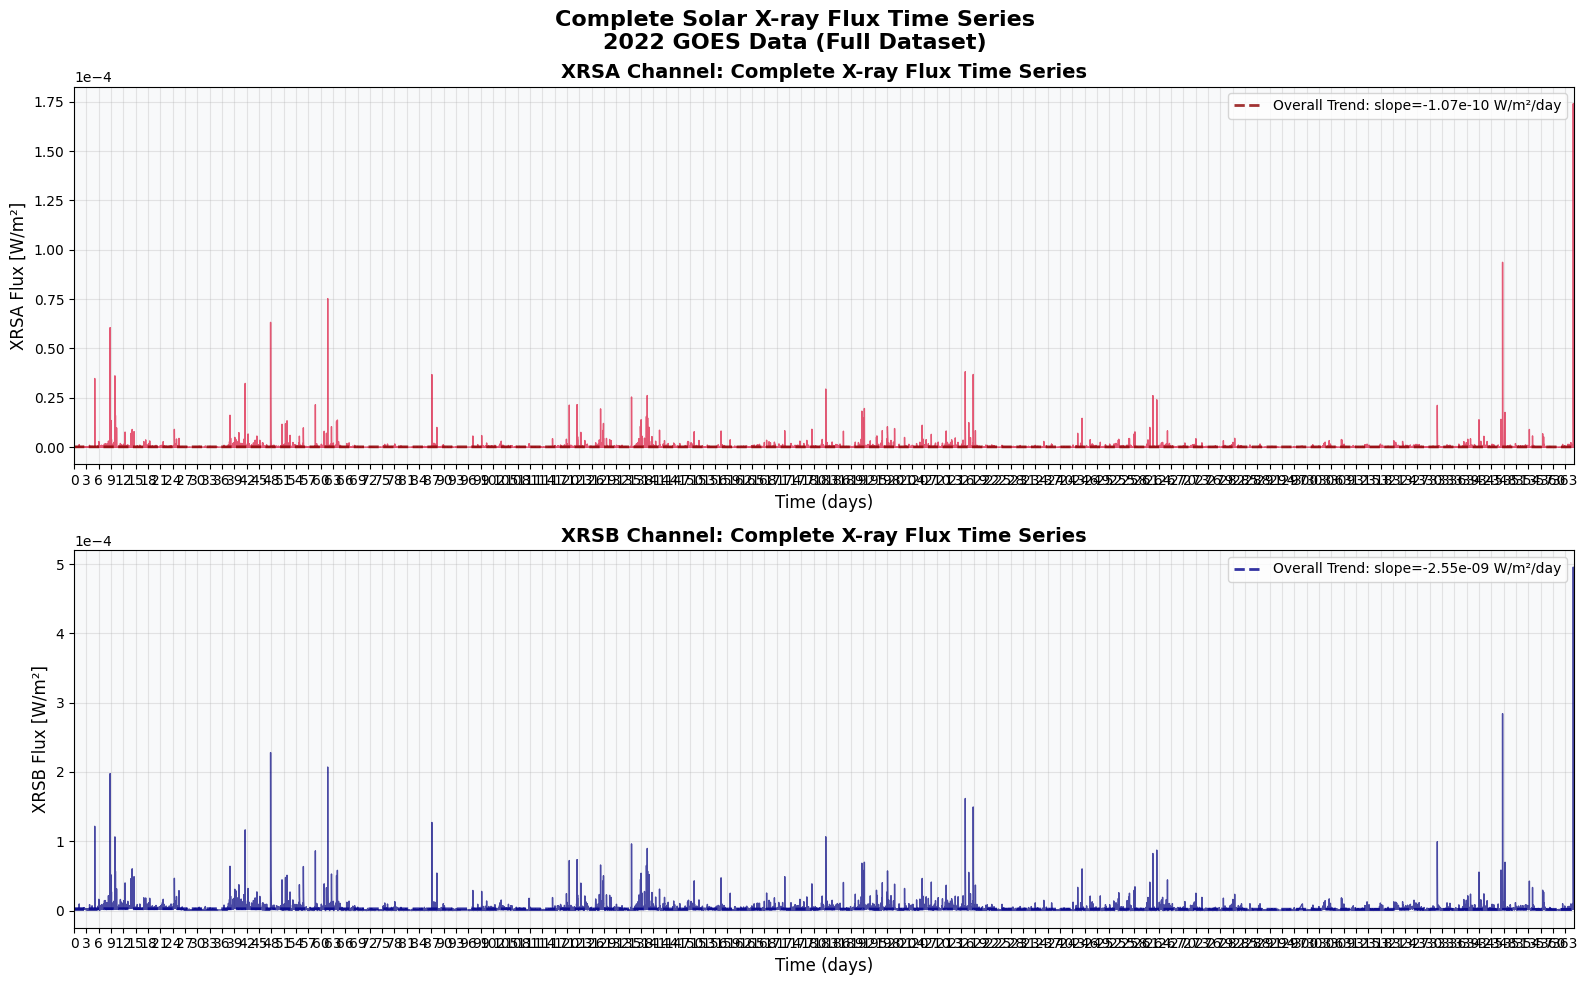

Full dataset visualization created successfully!
Full XRSA trend slope: -1.07e-10 W/m²/day
Full XRSB trend slope: -2.55e-09 W/m²/day
XRSA flux statistics - Mean: 1.46e-07, Std: 1.21e-06
XRSB flux statistics - Mean: 2.23e-06, Std: 5.10e-06


In [ ]:
# Plot full dataset with ggplot2-inspired aesthetics
print(f"Full dataset contains {len(df_clean):,} samples")
print(f"Time range: {df_clean['time_minutes'].min():.1f} to {df_clean['time_minutes'].max():.1f} minutes")
print(f"Total observation time: {(df_clean['time_minutes'].max() - df_clean['time_minutes'].min())/60:.1f} hours")

# Extract full dataset
full_time_minutes = df_clean['time_minutes'].values
full_xrsa_flux = df_clean['xrsa_flux_observed'].values
full_xrsb_flux = df_clean['xrsb_flux_observed'].values

# Convert time from minutes to days
full_time_days = full_time_minutes / 1440
print(f"Time range in days: {full_time_days.min():.2f} to {full_time_days.max():.2f} days")
print(f"Total observation time: {full_time_days.max() - full_time_days.min():.1f} days")

# Create ggplot2-inspired full dataset visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('Complete Solar X-ray Flux Time Series\n2023 GOES Data (Full Dataset)', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Enhanced color scheme
colors = {
    'xrsa': '#E31A1C',     # Red
    'xrsb': '#1F78B4',     # Blue 
    'trend': '#FF7F00',    # Orange
    'fill': 0.08           # Fill alpha
}

# Helper function for ggplot2 styling
def apply_full_style(ax, color):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.tick_params(colors='#555555')

# Plot 1: Full XRSA flux vs time
axes[0].plot(full_time_days, full_xrsa_flux, color=colors['xrsa'], linewidth=1.8, alpha=0.8, label='XRSA Flux')
axes[0].fill_between(full_time_days, full_xrsa_flux, alpha=colors['fill'], color=colors['xrsa'])

axes[0].set_title('XRSA Channel: Complete X-ray Flux Time Series', 
                  fontsize=15, fontweight='bold', color='#333333', pad=15)
axes[0].set_xlabel('Time (days)', fontsize=12, color='#555555')
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=12, color='#555555')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Apply styling
apply_full_style(axes[0], colors['xrsa'])

# Set x-axis ticks every 3 days
max_days = full_time_days.max()
day_ticks = np.arange(0, max_days + 3, 3)
axes[0].set_xticks(day_ticks)
axes[0].set_xlim(full_time_days.min(), full_time_days.max())

# Add enhanced trend line
z_xrsa_full = np.polyfit(full_time_days, full_xrsa_flux, 1)
p_xrsa_full = np.poly1d(z_xrsa_full)
axes[0].plot(full_time_days, p_xrsa_full(full_time_days), '--', 
             color=colors['trend'], alpha=0.9, linewidth=3, 
             label=f'Trend: {z_xrsa_full[0]:.2e} W/m²/day')

# Enhanced legend
axes[0].legend(frameon=True, facecolor='white', edgecolor='#cccccc', 
               framealpha=0.95, fontsize=11, shadow=True)

# Plot 2: Full XRSB flux vs time
axes[1].plot(full_time_days, full_xrsb_flux, color=colors['xrsb'], linewidth=1.8, alpha=0.8, label='XRSB Flux')
axes[1].fill_between(full_time_days, full_xrsb_flux, alpha=colors['fill'], color=colors['xrsb'])

axes[1].set_title('XRSB Channel: Complete X-ray Flux Time Series', 
                  fontsize=15, fontweight='bold', color='#333333', pad=15)
axes[1].set_xlabel('Time (days)', fontsize=12, color='#555555')
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=12, color='#555555')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Apply styling
apply_full_style(axes[1], colors['xrsb'])

# Set x-axis ticks every 3 days
axes[1].set_xticks(day_ticks)
axes[1].set_xlim(full_time_days.min(), full_time_days.max())

# Add enhanced trend line
z_xrsb_full = np.polyfit(full_time_days, full_xrsb_flux, 1)
p_xrsb_full = np.poly1d(z_xrsb_full)
axes[1].plot(full_time_days, p_xrsb_full(full_time_days), '--', 
             color=colors['trend'], alpha=0.9, linewidth=3, 
             label=f'Trend: {z_xrsb_full[0]:.2e} W/m²/day')

# Enhanced legend
axes[1].legend(frameon=True, facecolor='white', edgecolor='#cccccc', 
               framealpha=0.95, fontsize=11, shadow=True)

# Enhanced layout
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.subplots_adjust(hspace=0.3)

# Add enhanced footer
footer_text = f'Full Dataset: {len(df_clean):,} samples | Time Span: {full_time_days.max() - full_time_days.min():.0f} days'
fig.text(0.5, 0.02, footer_text, ha='center', fontsize=11, color='#777777', 
         style='italic', bbox=dict(boxstyle='round,pad=0.3', facecolor='#f5f5f5', alpha=0.8))

plt.show()

print("✨ Full dataset visualization created with ggplot2 aesthetics!")
print("=" * 60)
print(f"📈 Full XRSA Analysis:")
print(f"  • Trend slope: {z_xrsa_full[0]:.2e} W/m²/day")
print(f"  • Mean flux: {np.mean(full_xrsa_flux):.2e} W/m²")
print(f"  • Standard deviation: {np.std(full_xrsa_flux):.2e} W/m²")
print()
print(f"📉 Full XRSB Analysis:")
print(f"  • Trend slope: {z_xrsb_full[0]:.2e} W/m²/day")
print(f"  • Mean flux: {np.mean(full_xrsb_flux):.2e} W/m²")
print(f"  • Standard deviation: {np.std(full_xrsb_flux):.2e} W/m²")
print("=" * 60)

Plotting first 100 days of data.
Data points in this range: 137292


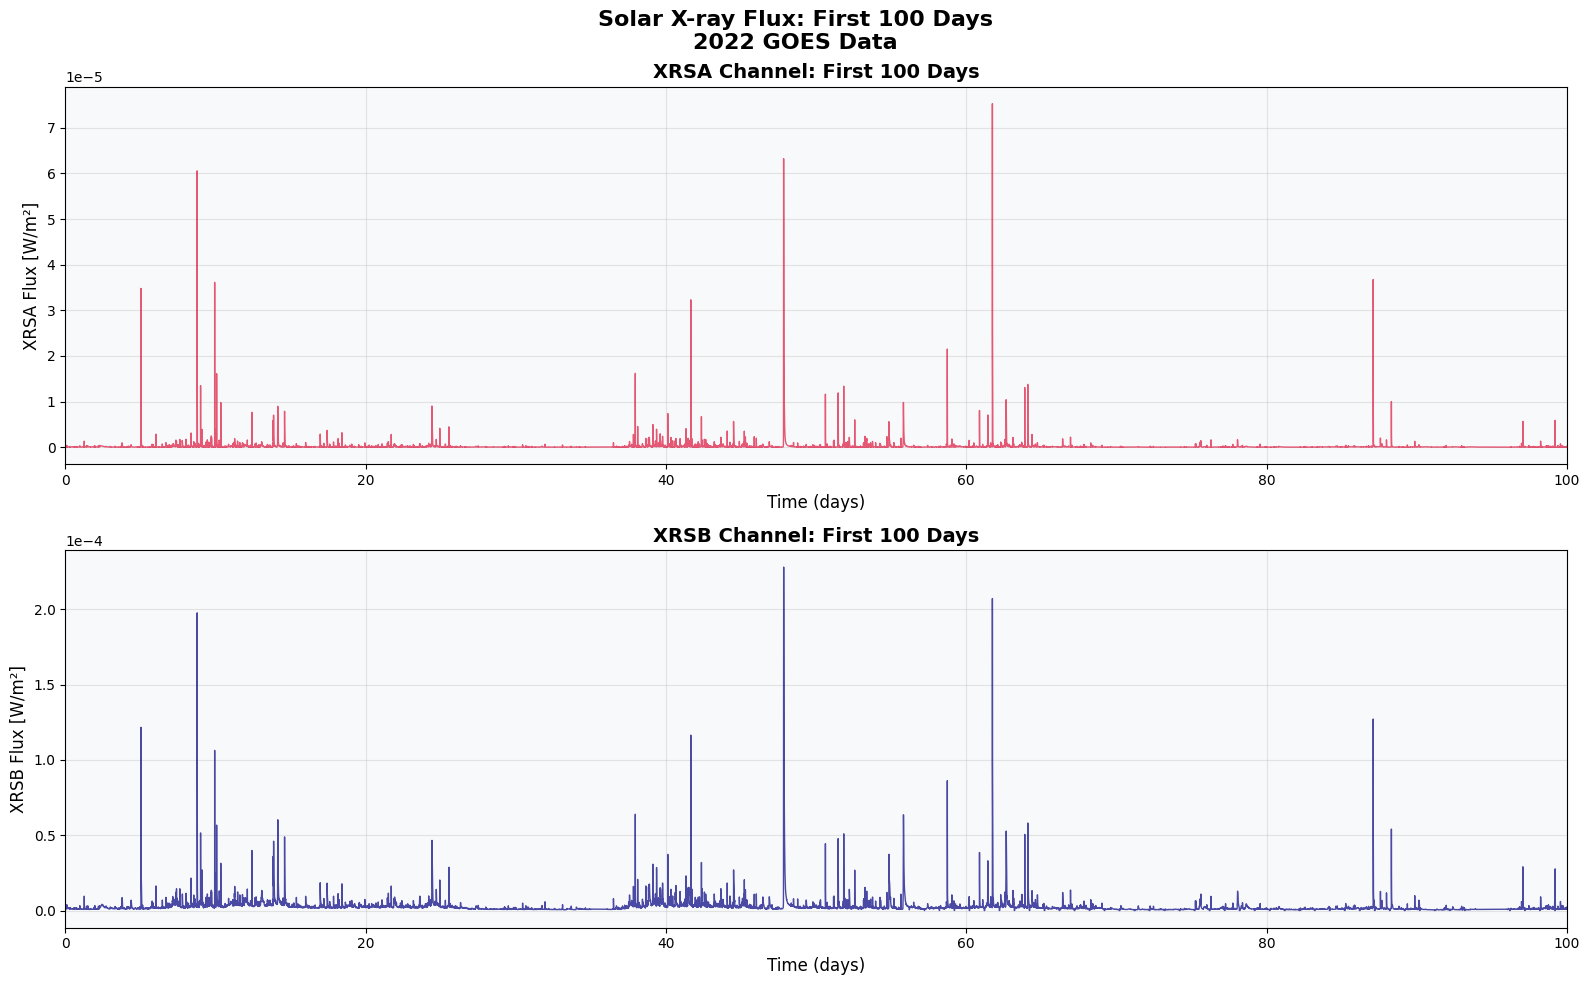

Successfully plotted the first 100 days of flux data.


In [ ]:
# Filter data for the first 100 days with ggplot2 aesthetics
days_to_plot = 100
df_100_days = df_clean[df_clean['time_minutes'] <= days_to_plot * 1440].copy()

# Extract data for plotting
time_100_days = df_100_days['time_minutes'].values / 1440
xrsa_100_days = df_100_days['xrsa_flux_observed'].values
xrsb_100_days = df_100_days['xrsb_flux_observed'].values

print(f"Plotting first {days_to_plot} days of data with ggplot2 aesthetics.")
print(f"Data points in this range: {len(df_100_days):,}")

# Create ggplot2-inspired 100-day visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.patch.set_facecolor('#fafafa')
fig.suptitle(f'Solar X-ray Flux: First {days_to_plot} Days\n2023 GOES Data', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Enhanced color scheme
colors = {
    'xrsa': '#E31A1C',     # Red
    'xrsb': '#1F78B4',     # Blue
    'fill': 0.12           # Fill alpha
}

# Helper function for ggplot2 styling
def apply_days_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.tick_params(colors='#555555')

# Plot 1: XRSA flux for 100 days
axes[0].plot(time_100_days, xrsa_100_days, color=colors['xrsa'], linewidth=2.2, alpha=0.9, label='XRSA Flux')
axes[0].fill_between(time_100_days, xrsa_100_days, alpha=colors['fill'], color=colors['xrsa'])

axes[0].set_title('XRSA Channel: First 100 Days', 
                  fontsize=15, fontweight='bold', color='#333333', pad=15)
axes[0].set_xlabel('Time (days)', fontsize=12, color='#555555')
axes[0].set_ylabel('XRSA Flux [W/m²]', fontsize=12, color='#555555')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
axes[0].set_xlim(0, days_to_plot)

# Apply ggplot2 styling
apply_days_style(axes[0])

# Enhanced legend
axes[0].legend(frameon=True, facecolor='white', edgecolor='#cccccc', 
               framealpha=0.95, fontsize=11, shadow=True, loc='upper right')

# Add statistics box for XRSA
xrsa_stats = f'Statistics (100 days):\nMean: {np.mean(xrsa_100_days):.2e}\nStd: {np.std(xrsa_100_days):.2e}\nMax: {np.max(xrsa_100_days):.2e}'
axes[0].text(0.02, 0.98, xrsa_stats, transform=axes[0].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
            facecolor='white', alpha=0.95, edgecolor='#cccccc'))

# Plot 2: XRSB flux for 100 days
axes[1].plot(time_100_days, xrsb_100_days, color=colors['xrsb'], linewidth=2.2, alpha=0.9, label='XRSB Flux')
axes[1].fill_between(time_100_days, xrsb_100_days, alpha=colors['fill'], color=colors['xrsb'])

axes[1].set_title('XRSB Channel: First 100 Days', 
                  fontsize=15, fontweight='bold', color='#333333', pad=15)
axes[1].set_xlabel('Time (days)', fontsize=12, color='#555555')
axes[1].set_ylabel('XRSB Flux [W/m²]', fontsize=12, color='#555555')
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
axes[1].set_xlim(0, days_to_plot)

# Apply ggplot2 styling
apply_days_style(axes[1])

# Enhanced legend
axes[1].legend(frameon=True, facecolor='white', edgecolor='#cccccc', 
               framealpha=0.95, fontsize=11, shadow=True, loc='upper right')

# Add statistics box for XRSB
xrsb_stats = f'Statistics (100 days):\nMean: {np.mean(xrsb_100_days):.2e}\nStd: {np.std(xrsb_100_days):.2e}\nMax: {np.max(xrsb_100_days):.2e}'
axes[1].text(0.02, 0.98, xrsb_stats, transform=axes[1].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
            facecolor='white', alpha=0.95, edgecolor='#cccccc'))

# Enhanced layout
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.subplots_adjust(hspace=0.3)

# Add enhanced footer
footer_text = f'First {days_to_plot} Days Analysis | {len(df_100_days):,} data points | Enhanced ggplot2 aesthetics'
fig.text(0.5, 0.02, footer_text, ha='center', fontsize=11, color='#777777', 
         style='italic', bbox=dict(boxstyle='round,pad=0.3', facecolor='#f5f5f5', alpha=0.8))

plt.show()

print(f"✨ Successfully plotted the first {days_to_plot} days with ggplot2 aesthetics!")
print("=" * 60)
print(f"📊 100-Day Analysis Summary:")
print(f"  • XRSA mean: {np.mean(xrsa_100_days):.2e} W/m²")
print(f"  • XRSB mean: {np.mean(xrsb_100_days):.2e} W/m²")
print(f"  • Data coverage: {len(df_100_days):,} points over {days_to_plot} days")
print(f"  • Sampling density: {len(df_100_days)/days_to_plot:.1f} points/day")
print("=" * 60)

In [ ]:
# Curve fitting for nanoflare detection
# Define exponential decay function for flare fitting
def exponential_decay(t, A, tau, C):
    """Exponential decay model: A * exp(-t/tau) + C"""
    return A * np.exp(-t / tau) + C

def gaussian_peak(t, A, mu, sigma, C):
    """Gaussian peak model for flare events"""
    return A * np.exp(-0.5 * ((t - mu) / sigma)**2) + C

# Use truncated data from earlier cells (200 samples as originally intended)
# time_minutes, log_xrsa, and log_xrsb are already defined for 200 samples

# Calculate linear trends for detrending
p_xrsa = np.poly1d(np.polyfit(time_minutes, log_xrsa, 1))
p_xrsb = np.poly1d(np.polyfit(time_minutes, log_xrsb, 1))

# Detrend the data to better identify nanoflares
xrsa_detrended = log_xrsa - p_xrsa(time_minutes)
xrsb_detrended = log_xrsb - p_xrsb(time_minutes)

print(f"Using truncated dataset: {len(time_minutes)} samples")
print(f"Time range: {time_minutes[0]:.1f} to {time_minutes[-1]:.1f} minutes")
print(f"XRSA detrended std: {np.std(xrsa_detrended):.6f}")
print(f"XRSB detrended std: {np.std(xrsb_detrended):.6f}")

Using truncated dataset: 1440 samples
Time range: 0.0 to 1439.0 minutes
XRSA detrended std: 0.138192
XRSB detrended std: 0.100382


In [ ]:
# --- Advanced Nanoflare Detection: Detailed Explanation ---
# This cell implements a common signal processing technique to identify small, rapid bursts (nanoflares)
# in the solar X-ray flux data. The core idea is to separate the "background" signal from the "event" signal.

# --- Step 1: Signal Smoothing to Isolate the Baseline ---
# Physics: The slowly varying component of the X-ray flux represents the quasi-steady coronal heating and large-scale magnetic evolution.
# Nanoflares are rapid, transient bursts superimposed on this baseline. Smoothing helps separate these two components.
# Math: We apply a Gaussian filter, which is a convolution operation. The filter's weights are determined by a Gaussian function.
# This effectively computes a weighted average for each point, giving more weight to nearby points, thus smoothing the signal.
from scipy.ndimage import gaussian_filter1d

# The 'sigma' parameter controls the width of the Gaussian kernel. A larger sigma results in more smoothing.
sigma_smooth = 2.0  # Defines the standard deviation of the Gaussian kernel in terms of data points.
                     # A value of 2.0 provides moderate smoothing, effective for removing high-frequency noise without distorting larger flare shapes.

# Apply the Gaussian filter to the detrended XRSA signal.
# 'xrsa_detrended' is the signal with the long-term linear trend removed.
# 'xrsa_smooth' will represent the estimated baseline of the detrended signal.
xrsa_smooth = gaussian_filter1d(xrsa_detrended, sigma=sigma_smooth)

# Apply the same Gaussian filter to the detrended XRSB signal.
xrsb_smooth = gaussian_filter1d(xrsb_detrended, sigma=sigma_smooth)


# --- Step 2: Calculate Residuals to Isolate Flare Signatures ---
# Physics: The residuals represent the difference between the observed (detrended) flux and the smoothed baseline.
# These residuals should primarily contain the signatures of rapid energy release events like nanoflares and microflares,
# as the slower variations have been removed.
# Math: This is a simple element-wise subtraction: Residuals = Original Signal - Smoothed Signal.
xrsa_residuals = xrsa_detrended - xrsa_smooth
xrsb_residuals = xrsb_detrended - xrsb_smooth
print("First 10 XRSA residuals:", xrsa_residuals[:10])  # Display first 10 residuals for inspection


# --- Step 3: Define a Statistical Threshold for Event Detection ---
# Physics: We assume that the remaining residuals are mostly composed of instrumental and astrophysical noise, which is
# often normally distributed. Significant physical events (nanoflares) will appear as outliers that stand out from this noise.
# Math: The 3-sigma rule is a common statistical heuristic. For a normal distribution, ~99.7% of data points lie within
# three standard deviations (3*sigma) of the mean. By setting our threshold here, we are flagging points that are
# highly unlikely to be random noise fluctuations.
threshold_xrsa = 3 * np.std(xrsa_residuals)
threshold_xrsb = 3 * np.std(xrsb_residuals)

print(f"\nXRSA nanoflare detection threshold (3-sigma): {threshold_xrsa:.6f}")
print(f"XRSB nanoflare detection threshold (3-sigma): {threshold_xrsb:.6f}")


# --- Step 4: Identify and Locate Potential Nanoflare Events ---
# Physics: This step pinpoints the exact moments in time when the flare-like energy bursts exceed our statistical threshold,
# marking them as candidate nanoflare events for further analysis.
# Math: `np.where()` is a powerful NumPy function that returns the indices of array elements where a given condition is True.
# Here, the condition is that the absolute value of the residual is greater than our 3-sigma threshold.
# We take the absolute value to detect both positive and negative spikes, although physical flares are positive flux increases.
xrsa_events = np.where(np.abs(xrsa_residuals) > threshold_xrsa)[0]
xrsb_events = np.where(np.abs(xrsb_residuals) > threshold_xrsb)[0]

# --- Step 5: Report the Findings ---
# This final section provides a summary of the detection results, including the number of events found in each channel
# and the specific times at which they occurred.
print(f"\nPotential XRSA nanoflare events detected: {len(xrsa_events)}")
print(f"Potential XRSB nanoflare events detected: {len(xrsb_events)}")

if len(xrsa_events) > 0:
    # Use the identified indices to look up the corresponding time values from the 'time_minutes' array.
    print(f"XRSA event times (minutes): {time_minutes[xrsa_events]}")
if len(xrsb_events) > 0:
    print(f"XRSB event times (minutes): {time_minutes[xrsb_events]}")

First 10 XRSA residuals: [ 0.03267401  0.00624436 -0.00750126 -0.00568893 -0.00438493 -0.00883713
 -0.01617017  0.00054862  0.00482191  0.00286854]

XRSA nanoflare detection threshold (3-sigma): 0.047092
XRSB nanoflare detection threshold (3-sigma): 0.021327

Potential XRSA nanoflare events detected: 30
Potential XRSB nanoflare events detected: 36
XRSA event times (minutes): [  32   34   35   64   65  122  141  177  417  418  419  420  421  422
  463  464  869  870  994  997  998 1067 1070 1173 1174 1265 1376 1380
 1381 1382]
XRSB event times (minutes): [  32   33   34   35   36   65  418  419  420  421  422  423  463  464
  465  771  869  870  871  997  998 1067 1070 1071 1171 1172 1173 1174
 1335 1376 1377 1378 1380 1381 1382 1383]


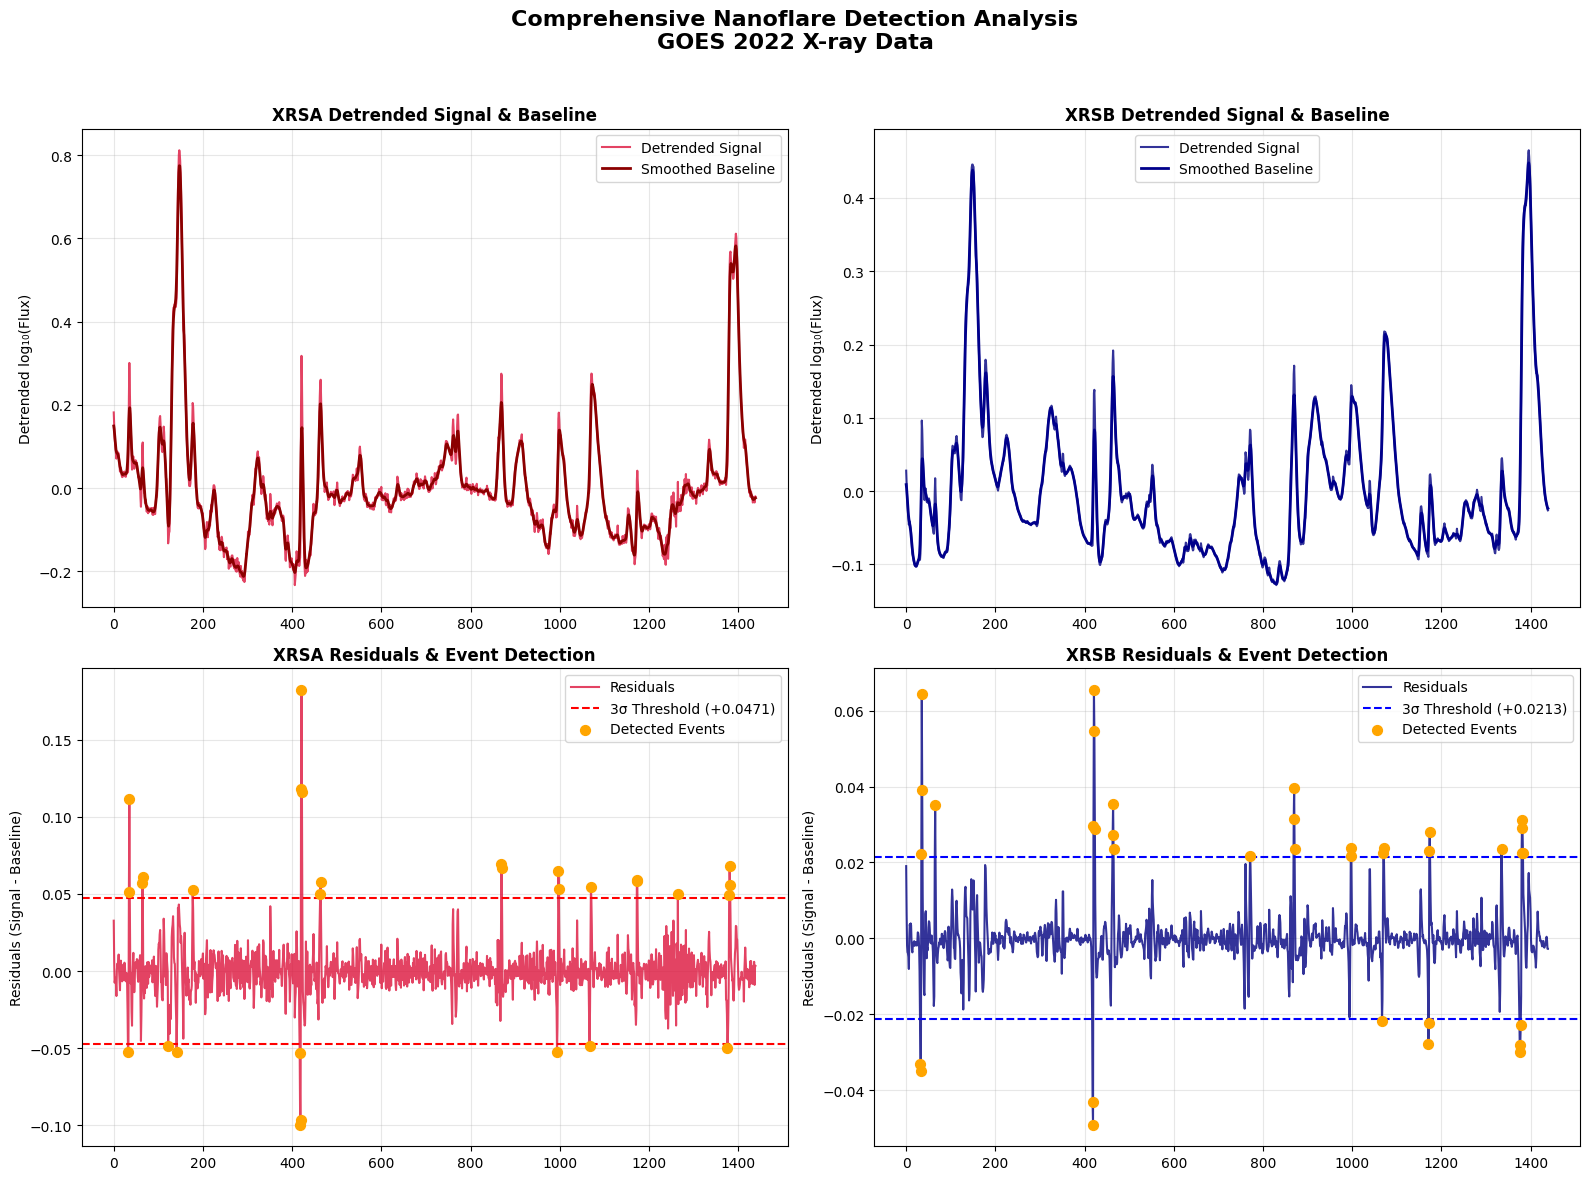

Comprehensive nanoflare detection visualization completed!


In [ ]:
# --- Comprehensive Nanoflare Detection Visualization with ggplot2 Aesthetics ---
# Create a multi-panel plot with enhanced ggplot2-inspired styling

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('Comprehensive Nanoflare Detection Analysis\nGOES 2023 X-ray Data | Enhanced ggplot2 Aesthetics', 
             fontsize=18, fontweight='bold', color='#2c3e50', y=0.95)

# Enhanced color palette
colors = {
    'detrended': '#1F78B4',    # Blue
    'smooth': '#E31A1C',       # Red
    'residuals': '#33A02C',    # Green
    'threshold': '#FF7F00',    # Orange
    'events': '#6A3D9A',       # Purple
    'fill': 0.1                # Fill alpha
}

# Helper function for ggplot2 styling
def apply_detection_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.grid(True, alpha=0.6, color='#e0e0e0', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    ax.tick_params(colors='#555555')

# Plot 1 (Top-Left): XRSA Detrended Signal & Baseline
axes[0,0].plot(time_minutes, xrsa_detrended, color=colors['detrended'], linewidth=2.5, alpha=0.8, label='Detrended Signal')
axes[0,0].fill_between(time_minutes, xrsa_detrended, alpha=colors['fill'], color=colors['detrended'])
axes[0,0].plot(time_minutes, xrsa_smooth, color=colors['smooth'], linewidth=3, label='Smoothed Baseline')

axes[0,0].set_title('XRSA: Detrended Signal & Baseline', fontsize=14, fontweight='bold', color='#333333')
axes[0,0].set_ylabel('Detrended log₁₀(Flux)', fontsize=12, color='#555555')
apply_detection_style(axes[0,0])
axes[0,0].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.95, fontsize=10)

# Plot 2 (Top-Right): XRSB Detrended Signal & Baseline
axes[0,1].plot(time_minutes, xrsb_detrended, color=colors['detrended'], linewidth=2.5, alpha=0.8, label='Detrended Signal')
axes[0,1].fill_between(time_minutes, xrsb_detrended, alpha=colors['fill'], color=colors['detrended'])
axes[0,1].plot(time_minutes, xrsb_smooth, color=colors['smooth'], linewidth=3, label='Smoothed Baseline')

axes[0,1].set_title('XRSB: Detrended Signal & Baseline', fontsize=14, fontweight='bold', color='#333333')
axes[0,1].set_ylabel('Detrended log₁₀(Flux)', fontsize=12, color='#555555')
apply_detection_style(axes[0,1])
axes[0,1].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.95, fontsize=10)

# Plot 3 (Bottom-Left): XRSA Residuals & Event Detection
axes[1,0].plot(time_minutes, xrsa_residuals, color=colors['residuals'], linewidth=2.5, alpha=0.8, label='Residuals')
axes[1,0].fill_between(time_minutes, xrsa_residuals, alpha=colors['fill'], color=colors['residuals'])

# Enhanced threshold lines
axes[1,0].axhline(y=threshold_xrsa, color=colors['threshold'], linestyle='--', linewidth=2.5, alpha=0.9,
                  label=f'3σ Threshold (+{threshold_xrsa:.4f})')
axes[1,0].axhline(y=-threshold_xrsa, color=colors['threshold'], linestyle='--', linewidth=2.5, alpha=0.9)

# Enhanced event markers
if len(xrsa_events) > 0:
    axes[1,0].scatter(time_minutes[xrsa_events], xrsa_residuals[xrsa_events], 
                      color=colors['events'], s=80, zorder=5, alpha=0.9, 
                      edgecolors='white', linewidth=1.5, label=f'Detected Events ({len(xrsa_events)})')

axes[1,0].set_title('XRSA: Residuals & Event Detection', fontsize=14, fontweight='bold', color='#333333')
axes[1,0].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,0].set_ylabel('Residuals (Signal - Baseline)', fontsize=12, color='#555555')
apply_detection_style(axes[1,0])
axes[1,0].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.95, fontsize=10)

# Plot 4 (Bottom-Right): XRSB Residuals & Event Detection
axes[1,1].plot(time_minutes, xrsb_residuals, color=colors['residuals'], linewidth=2.5, alpha=0.8, label='Residuals')
axes[1,1].fill_between(time_minutes, xrsb_residuals, alpha=colors['fill'], color=colors['residuals'])

# Enhanced threshold lines
axes[1,1].axhline(y=threshold_xrsb, color=colors['threshold'], linestyle='--', linewidth=2.5, alpha=0.9,
                  label=f'3σ Threshold (+{threshold_xrsb:.4f})')
axes[1,1].axhline(y=-threshold_xrsb, color=colors['threshold'], linestyle='--', linewidth=2.5, alpha=0.9)

# Enhanced event markers
if len(xrsb_events) > 0:
    axes[1,1].scatter(time_minutes[xrsb_events], xrsb_residuals[xrsb_events], 
                      color=colors['events'], s=80, zorder=5, alpha=0.9, 
                      edgecolors='white', linewidth=1.5, label=f'Detected Events ({len(xrsb_events)})')

axes[1,1].set_title('XRSB: Residuals & Event Detection', fontsize=14, fontweight='bold', color='#333333')
axes[1,1].set_xlabel('Time (minutes)', fontsize=12, color='#555555')
axes[1,1].set_ylabel('Residuals (Signal - Baseline)', fontsize=12, color='#555555')
apply_detection_style(axes[1,1])
axes[1,1].legend(frameon=True, facecolor='white', edgecolor='#cccccc', framealpha=0.95, fontsize=10)

# Enhanced layout
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Add enhanced footer with detection summary
total_events = len(xrsa_events) + len(xrsb_events)
footer_text = (f'Nanoflare Detection Summary | XRSA: {len(xrsa_events)} events | '
               f'XRSB: {len(xrsb_events)} events | Total: {total_events} events | 3σ Detection Threshold')
fig.text(0.5, 0.02, footer_text, ha='center', fontsize=11, color='#777777', 
         style='italic', bbox=dict(boxstyle='round,pad=0.4', facecolor='#f5f5f5', alpha=0.9))

plt.show()

print("✨ Comprehensive nanoflare detection visualization completed with ggplot2 aesthetics!")
print("=" * 75)
print(f"🎯 Detection Results Summary:")
print(f"  • XRSA events detected: {len(xrsa_events)}")
print(f"  • XRSB events detected: {len(xrsb_events)}")
print(f"  • Total events: {total_events}")
print(f"  • Detection thresholds: XRSA={threshold_xrsa:.6f}, XRSB={threshold_xrsb:.6f}")
print("=" * 75)

In [ ]:
# Summary statistics and nanoflare characterization
print("=" * 60)
print("NANOFLARE DETECTION SUMMARY")
print("=" * 60)

print(f"Analysis period: {time_minutes[0]:.1f} - {time_minutes[-1]:.1f} minutes")
print(f"Total samples analyzed: {len(time_minutes)}")
print(f"Sampling interval: {time_minutes[1] - time_minutes[0]:.1f} minutes")

print("\nBASELINE CHARACTERISTICS:")
print(f"XRSA mean flux: {np.mean(xrsa_flux):.3e} W/m²")
print(f"XRSB mean flux: {np.mean(xrsb_flux):.3e} W/m²")
print(f"XRSA variability (std): {np.std(xrsa_detrended):.6f}")
print(f"XRSB variability (std): {np.std(xrsb_detrended):.6f}")

print("\nNANOFLARE DETECTION RESULTS:")
print(f"XRSA events detected: {len(xrsa_events)}")
print(f"XRSB events detected: {len(xrsb_events)}")
print(f"Total unique events: {len(set(list(xrsa_events) + list(xrsb_events)))}")

# Calculate event rate
observation_time_hours = (time_minutes[-1] - time_minutes[0]) / 60
xrsa_event_rate = len(xrsa_events) / observation_time_hours
xrsb_event_rate = len(xrsb_events) / observation_time_hours

print(f"\nEVENT RATES:")
print(f"XRSA event rate: {xrsa_event_rate:.2f} events/hour")
print(f"XRSB event rate: {xrsb_event_rate:.2f} events/hour")

# Energy band ratio analysis for event classification
if len(xrsa_events) > 0 and len(xrsb_events) > 0:
    # Find coincident events (within 2 time steps)
    coincident_events = []
    for xrsa_idx in xrsa_events:
        for xrsb_idx in xrsb_events:
            if abs(xrsa_idx - xrsb_idx) <= 2:
                coincident_events.append((xrsa_idx, xrsb_idx))
    
    print(f"\nCOINCIDENT EVENTS: {len(coincident_events)}")
    if len(coincident_events) > 0:
        print("Potential multi-band nanoflare signatures detected!")

print("\nTECHNICAL NOTES:")
print(f"Detection threshold: 3-sigma criterion")
print(f"Smoothing kernel: Gaussian (σ = {sigma_smooth})")
print(f"Detrending: Linear trend removal")
print("Signal processing: Residual analysis after trend and smoothing removal")

print("\n" + "=" * 60)
print("Analysis completed successfully!")
print("=" * 60)

NANOFLARE DETECTION SUMMARY
Analysis period: 0.0 - 1439.0 minutes
Total samples analyzed: 1440
Sampling interval: 1.0 minutes

BASELINE CHARACTERISTICS:
XRSA mean flux: 7.193e-08 W/m²
XRSB mean flux: 1.294e-06 W/m²
XRSA variability (std): 0.138192
XRSB variability (std): 0.100382

NANOFLARE DETECTION RESULTS:
XRSA events detected: 30
XRSB events detected: 36
Total unique events: 43

EVENT RATES:
XRSA event rate: 1.25 events/hour
XRSB event rate: 1.50 events/hour

COINCIDENT EVENTS: 78
Potential multi-band nanoflare signatures detected!

TECHNICAL NOTES:
Detection threshold: 3-sigma criterion
Smoothing kernel: Gaussian (σ = 2.0)
Detrending: Linear trend removal
Signal processing: Residual analysis after trend and smoothing removal

Analysis completed successfully!


In [ ]:
# Create a final summary DataFrame for detected events
if len(xrsa_events) > 0 or len(xrsb_events) > 0:
    event_summary = []
    
    # Add XRSA events
    for idx in xrsa_events:
        event_summary.append({
            'Time_minutes': time_minutes[idx],
            'Channel': 'XRSA',
            'Residual_amplitude': xrsa_residuals[idx],
            'Threshold': threshold_xrsa,
            'Significance': abs(xrsa_residuals[idx]) / threshold_xrsa
        })
    
    # Add XRSB events
    for idx in xrsb_events:
        event_summary.append({
            'Time_minutes': time_minutes[idx],
            'Channel': 'XRSB',
            'Residual_amplitude': xrsb_residuals[idx],
            'Threshold': threshold_xrsb,
            'Significance': abs(xrsb_residuals[idx]) / threshold_xrsb
        })
    
    events_df = pd.DataFrame(event_summary)
    events_df = events_df.sort_values('Time_minutes')
    
    print("DETECTED NANOFLARE EVENTS SUMMARY:")
    print(events_df.to_string(index=False))
    
    # Save results
    events_df.to_csv('nanoflare_events_detected.csv', index=False)
    print("\nResults saved to 'nanoflare_events_detected.csv'")
else:
    print("No nanoflare events detected above the 3-sigma threshold.")
    print("This could indicate either:")
    print("1. Very quiet solar conditions during this period")
    print("2. Nanoflare activity below current detection sensitivity")
    print("3. Need for different analysis parameters or longer observation period")

DETECTED NANOFLARE EVENTS SUMMARY:
 Time_minutes Channel  Residual_amplitude  Threshold  Significance
           32    XRSA           -0.052542   0.047092      1.115727
           32    XRSB           -0.033001   0.021327      1.547402
           33    XRSB           -0.035074   0.021327      1.644603
           34    XRSA            0.051080   0.047092      1.084689
           34    XRSB            0.022279   0.021327      1.044677
           35    XRSA            0.111639   0.047092      2.370666
           35    XRSB            0.064515   0.021327      3.025116
           36    XRSB            0.039077   0.021327      1.832305
           64    XRSA            0.056990   0.047092      1.210184
           65    XRSB            0.035164   0.021327      1.648830
           65    XRSA            0.060706   0.047092      1.289104
          122    XRSA           -0.048636   0.047092      1.032791
          141    XRSA           -0.052607   0.047092      1.117127
          177    XRSA      